<p style="font-size:xx-large">Table of contents</p>

1. [Setup](#setup)
    1. [Imports](#imports)
    2. [Wildfire Information](#wildfire-info)
    3. [File Constants](#file-constants)
2. [Data Collection](#data-collection)
3. [Image Processing](#image-processing)
    1. [Wildifre Area](#wildfire-area)
    2. [Morphology](#morphology)
4. [Land Cover Classification](#land-cover-classification)
    1. [Land Cover Datasets](#land-cover-datasets)
    2. [Interactive Map](#interactive-map)
5. [Wind Data](#wind-data)
    1. [Create Wind Map](#wind-map)

<a name="setup"></a>
# Setup

<a name="imports"></a>
## Imports

In [1]:
import datetime as dt
import json
import os

import ee
import matplotlib.pyplot as plt
import numpy as np

from sentinelsat import SentinelAPI

In [2]:
# If you have never authenticated, this will raise an exception
# and prompt you to authenticate. You only need to do this once.
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

Input the name of the location where the wildfire occurred. Examples are:
* Istres
* Montguers
* etc.

In [3]:
# Name of the place where the fire is located
try:
    FIRE_NAME = input("Name of the fire: ").lower()
except ValueError:
    print("Please enter a valid name.")

# Folder where the JP2 images will be stored
PATH = f'data/{FIRE_NAME}/'
# Path to the folders where the TIFF, PNG, and GIF files will be stored
OUTPUT_FOLDER = f"output/{FIRE_NAME}/"
OUTPUT_MAPS = OUTPUT_FOLDER + "maps/"

<a name="wildfire-info"></a>
## Wildfire information

In [4]:
with open(f"data/info_fires/info_{FIRE_NAME}.json") as f:
    fire_info = json.load(f)

# Date of the fire
WILDFIRE_DATE = dt.datetime.strptime(fire_info["wildfire_date"], "%Y-%m-%d")
# Coordinates of the fire
LATITUDE, LONGITUDE = fire_info["latitude"], fire_info["longitude"]
# Actual area in hectares that burned. We retrieved the area on the news
TRUE_AREA = fire_info["true_area"]

In [5]:
# Path to the GeoJSON file
GEOJSON_PATH = f"data/geojson_files/{FIRE_NAME}.geojson"
# Path to the JSON file where the Sentinel API credentials are stored
CREDENTIALS_PATH = "secrets/sentinel_api_credentials.json"

<a name="file-constants"></a>
## File constants

* <u>Observation interval</u>:
<p>The observation interval is somewhat arbitrary, but longer ranges allow us to retrieve more images, since they are taken every 5 days. Furthermore, the burned area is visible for a few weeks, even months, after the fire started.</p>


* <u>Resolution</u>:
<p>As of right now, we only use the <b>NDVI</b> of an image for the processing steps. The necessary bands, <code>B08</code> (near-infrared) and <code>B04</code> (red) are available at all resolutions (10, 20, and 60 m) but for better results we use 10.
Other indexes, such as <i>SWIR</i>, need resolutions 20 or 60 but are not yet implemented.</p>


* <u>Cloud threshold</u>:
<p>We only retrieve the images below this threshold, because otherwise they are mostly no-data images or yield no valuable results.</p>


* <u>Thresholds</u>:
<p>After calculating the difference in NDVI, we reduce the "noise" of the image by thresholding the values. All values below the threshold are set to 0, so that the burned area stands out.</p>


* <u>Samples</u>:
<p>After retrieving the land cover data, we use sample coordinates to create the pie charts.</p>

In [6]:
# Number of days both before and after the fire to get images
OBSERVATION_INTERVAL = 15
# Resolution of the images (10m, 20m, or 60m)
RESOLUTION = 10
# Threshold for the cloud cover (between 0 and 100)
CLOUD_THRESHOLD = 40
# Seed for random number generator (for reproductibility)
SEED = 42
# Threshold values for calculating the area that burned
THRESHOLDS = np.arange(0.05, 0.41, 0.01)
# Number of coordinates to use for the pie charts
SAMPLES = np.arange(50, 1001, 50)

<a name="data-collection"></a>
# Data Collection

In [7]:
import utils.data_collection as dc

In [8]:
with open(CREDENTIALS_PATH, 'r') as infile:
    credentials = json.load(infile)

api = SentinelAPI(
    credentials["username"],
    credentials["password"]
)

In [9]:
if not os.path.exists(PATH):
    os.makedirs(PATH)

This is the main function that retrieves and downloads the relevant images. Many functions are called, available in [data_collection.py](utils/data_collection.py). The main idea is that we retrieve the images with the most information: less cloud coverage, less water presence, and larger in size (since no-data images are smaller).

You may get the error __Product ... is not online. Triggered retrieval from Long Term Archive__, specially with older images. Unfortunately, the only solution we have found is to wait for 15-30 minutes (maybe more) and then try again.

Another error, __NullPointerException__ may occur, but the solution is the same: try again after a few minutes.

If you get the error __Index .. is out of bounds for axis 0 with size ..__, it means that a suitable image was not found. To solve the problem, you can try extending the observation interval by a few days, or lower the minimum size required for the images (it is set at 980 MB) inside the data collection file.

In [10]:
if not dc.check_downloaded_data(PATH, OUTPUT_FOLDER, FIRE_NAME):
    try:
        dc.get_before_after_images(
            api=api,
            wildfire_date=WILDFIRE_DATE,
            geojson_path=GEOJSON_PATH,
            observation_interval=OBSERVATION_INTERVAL,
            path=PATH,
            fire_name=FIRE_NAME,
            output_folder=OUTPUT_FOLDER,
            resolution=RESOLUTION,
            cloud_threshold=CLOUD_THRESHOLD
        )
    except Exception as e:
        print(e)
        exit()

Data has already been downloaded.


<a name="image-processing"></a>
# Image Processing

The first step here is to retrieve the location of the fire inside the produced NDVI image. Instead of doing this manually, we can transform the coordinates from the JSON info file into pixel values. Then, we plot the pixels inside the image.

In [11]:
import utils.image_processing as ip

In [ ]:
ip.plot_downloaded_images(FIRE_NAME, OUTPUT_FOLDER)

In [12]:
img_folder = PATH + os.listdir(PATH)[1] + '/'
print(img_folder)

pixel_column, pixel_row = ip.get_fire_pixels(
    img_folder, LATITUDE, LONGITUDE
)

data/tuzan/S2B_MSIL2A_20200806T105619_N0214_R094_T30TXQ_20200806T131026.SAFE/


In [13]:
diff = ip.get_ndvi_difference(
    OUTPUT_FOLDER, FIRE_NAME, save_diff=False
)

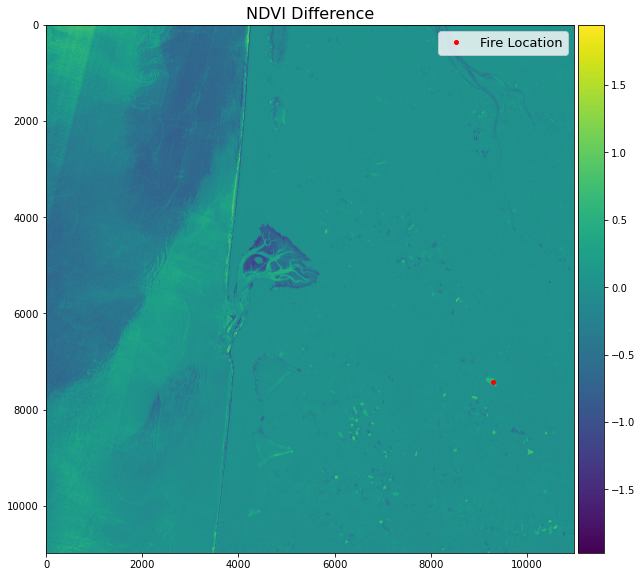

In [14]:
ax = ip.imshow(diff, figsize=(10, 10), title='NDVI Difference')
ip.plot_location(ax, pixel_column, pixel_row)

Next, we ask the user to give pixel values to add lines to the image to zoom-in on the area of interest. We have explored methods to do this automatically but we have not been successful for now.

In [15]:
print(f'The fire is located at pixels ({pixel_column}, {pixel_row}).\n')

The fire is located at pixels (9287, 7424).



Enter the first vertical line.
                Value must be an integer between 0 and 10980:
Enter the second vertical line.
                Value must be an integer between 9100 and 10980:
Enter the first horizontal line.
                Value must be an integer between 0 and 10980:
Enter the second horizontal line.
                Value must be an integer between 7300 and 10980:
Your inputs:
                1st vertical line: 9100
                2nd vertical line: 9450
                1st horizontal line: 7300
                2nd horizontal line: 7550
                


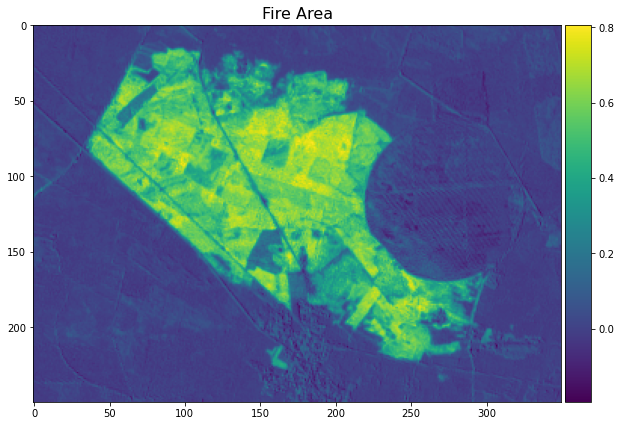

In [16]:
fire, hline_1, vline_1 = ip.retrieve_fire_area(
    diff, pixel_column, pixel_row,
    figsize=(10, 10), title='Fire Area'
)

<a name="wildifre-area"></a>
## Wildfire area

Here we calculate the area that burned thanks to the difference in NDVI and we plot the results, along with the true value. This helps us to validate our functions.

In [17]:
areas = []
for thr in THRESHOLDS:
    tmp = ip.threshold_filter(fire, thr)
    area = round(ip.calculate_area(tmp, diff) * 100, 4)
    areas.append(area)

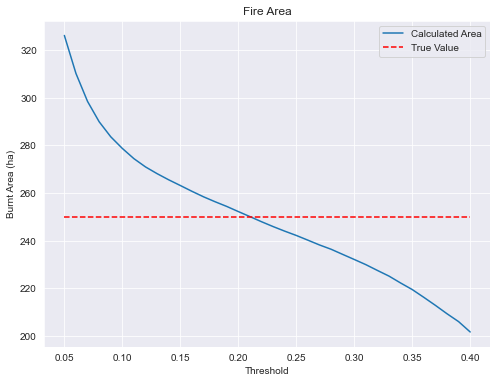

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 6))
with sns.axes_style('darkgrid'):
    plt.plot(THRESHOLDS, areas)
    plt.hlines(TRUE_AREA, THRESHOLDS[0], THRESHOLDS[-1],
               colors='r', linestyles='dashed')
    plt.xlabel('Threshold')
    plt.ylabel('Burnt Area (ha)')
    plt.title('Fire Area')
    plt.legend(['Calculated Area', 'True Value'])
    plt.show()

In [19]:
while True:
    try:
        threshold = float(input('Enter a threshold value between -1 and 1: '))
        if -1 < threshold < 1:
            break
        else:
            raise ValueError
    except ValueError:
        print('Please enter a valid number.')

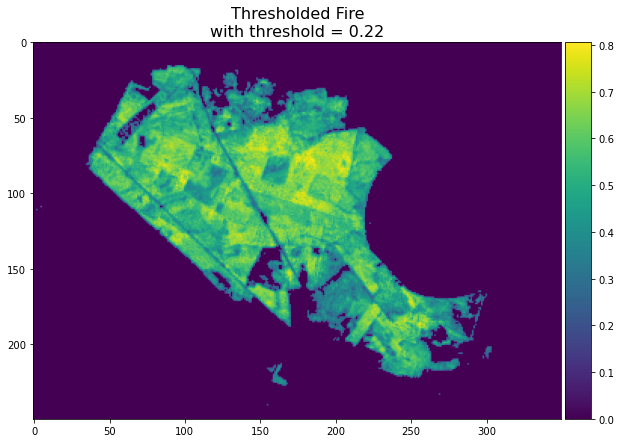

In [20]:
tmp = ip.threshold_filter(fire, threshold)
ax = ip.imshow(tmp, figsize=(10, 10), title=f'Thresholded Fire\nwith threshold = {threshold}')
plt.show()

In [21]:
print('Calculated area:', round(ip.calculate_area(tmp, diff) * 100, 4), 'ha.')

Calculated area: 247.94 ha.


In [22]:
print(f'The true area that burned is {TRUE_AREA} hectares.\n')

The true area that burned is 250.0 hectares.



<a name="morphology"></a>
## Morphology

For the final step in the image processing part, we use mathematical morphology to slighlty improve the quality of the image. More details are available here: [https://scikit-image.org/docs/stable/api/skimage.morphology.html](https://scikit-image.org/docs/stable/api/skimage.morphology.html).

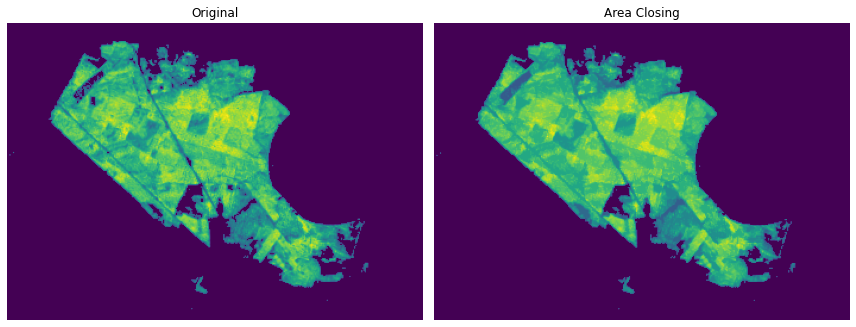

In [23]:
from skimage.morphology import area_closing

closed = area_closing(tmp)
ip.plot_comparison(tmp, closed, 'Area Closing')

In [24]:
print('Area after morphology:', round(ip.calculate_area(closed, diff) * 100, 4), 'ha.')

Area after morphology: 251.59 ha.


You can see a small difference between the images: the bright areas are more "connected", whereas the dark spots are dimmer. This is why the calculated area is a little larger.

Once you're satisfied with the results, execute the next cell.

In [25]:
fire = closed.copy()
del tmp
del closed

<a name="land-cover-classification"></a>
# Land Cover Classification

<a name="land-cover-datasets"></a>
## Land cover datasets

The next step consists in retrieving information on the type of land that was affected by the fire, such as crops or forests. Multiple datasets are available from Earth Engine's catalog. They use different resolutions and time ranges. The ones we use are:
* [MODIS Land Cover](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1?hl=en) _(2018, 500m)_
* [ESA World Cover](https://developers.google.com/earth-engine/datasets/catalog/ESA_WorldCover_v100) _(2020, 10m)_
* [Copernicus Global Land Service](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global) _(2019, 100m)_
* [Copernicus CORINE Land Cover](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_CORINE_V20_100m) _(2018, 100m)_. *Note: this dataset only covers Europe, so keep this in mind if you want information about wildfires in other continents.*

In [12]:
import utils.land_coverage as land_c

In [13]:
choice = land_c.get_choice()

Please select the land cover data you want to use.
                The choices are:
                1. MODIS Land Cover (2018, 500m)
                2. ESA World Cover (2020, 10m)
                3. Copernicus Global Land Service (2019, 100m)
                4. Copernicus CORINE Land Cover (2018, 100m)


This is the selected land cover dataframe:

In [28]:
lc_dataframe = land_c.get_land_cover_dataframe(choice)
lc_dataframe

,Value,Color,Description
0,10,#006400,Trees
1,20,#ffbb22,Shrubland
2,30,#ffff4c,Grassland
3,40,#f096ff,Cropland
4,50,#fa0000,Built-up
5,60,#b4b4b4,Barren / sparse vegetation
6,70,#f0f0f0,Snow and ice
7,80,#0064c8,Open water
8,90,#0096a0,Herbaceous wetland
9,95,#00cf75,Mangroves


In [29]:
while True:
    try:
        prob = input(
            'Enter sample percentage to use for land cover classification: '
        )
        prob = prob[:-1] if prob[-1] == '%' else prob
        prob = float(prob) / 100
        if 0 < prob <= 1:
            break
        else:
            raise ValueError
    except ValueError:
        print('Please enter a valid number.')

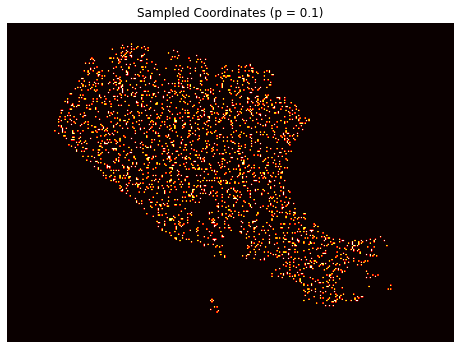

In [31]:
rand_image = land_c.create_sample_coordinates(fire, SEED, prob)
plt.figure(figsize=(8, 6))
plt.imshow(rand_image, cmap='hot')
plt.title(f'Sampled Coordinates (p = {prob})')
plt.axis('off')
plt.show()

Conversely, we can transform pixel values from the image into coordinates.

In [32]:
coordinates = land_c.get_coordinates_from_pixels(
    rand_image, hline_1, vline_1, img_folder, FIRE_NAME
)
coordinates

,latitude,longitude
0,44.469729,-0.586477
1,44.469657,-0.587360
2,44.469557,-0.586862
3,44.469549,-0.586485
4,44.469535,-0.585857
...,...,...
2539,44.451027,-0.579079
2540,44.451021,-0.578828
2541,44.450855,-0.579463
2542,44.450749,-0.578713


In [ ]:
lc = land_c.select_land_cover_data(choice)
scale = 1000
lc_type = []

In [ ]:
for _, (lat, lon) in coordinates.iterrows():
    u_poi = ee.Geometry.Point(lon, lat)
    try:
        lc_urban_point = land_c.get_lc_urban_point(lc, choice, u_poi, scale)
        lc_type.append(lc_urban_point)
    except Exception as e:
        print(e)

if None in lc_type:
    lc_type = [i for i in lc_type if i]

In [ ]:
coordinates["land_cover_type"] = lc_type
coordinates.head()

In [ ]:
coordinates.to_csv(f'../{FIRE_NAME}_with_lc.csv', index=False)

In [ ]:
import folium

mapa = folium.Map(location=[LATITUDE, LONGITUDE], zoom_start=12,
           tiles='Stamen Terrain')

for grp_name, df_grp in coordinates.groupby('land_cover_type'):
    feature_group = folium.FeatureGroup(grp_name)
    for row in df_grp.itertuples():
        folium.Marker(location=[row.latitude, row.longitude]).add_to(feature_group)
    feature_group.add_to(mapa)

folium.LayerControl().add_to(mapa)
mapa

In [33]:
output_folder = f"output/{FIRE_NAME}/pie_charts/"
exists = os.path.exists(output_folder)
if not exists:
    os.makedirs(output_folder)
is_empty = not any(os.scandir(output_folder))

After asking the user for a land cover dataset, we create a GIF file from the pie charts, to see the evolution of land cover information we obtain.

In [34]:
if exists and is_empty or not exists:
    land_c.create_plots(
        samples=SAMPLES,
        coordinates=coordinates,
        choice=choice,
        seed=SEED,
        fire_name=FIRE_NAME,
        out_folder=output_folder,
        save_fig=True
    )

In [35]:
land_c.make_pie_chart_gif(
    fire_name=FIRE_NAME,
    file_path=output_folder,
    save_all=True,
    duration=500,
    loop=0
)

You can open the GIF using your default program:

In [36]:
land_c.open_gif(FIRE_NAME, output_folder)

Or, alternatively, you can display the GIF directly in the notebook:


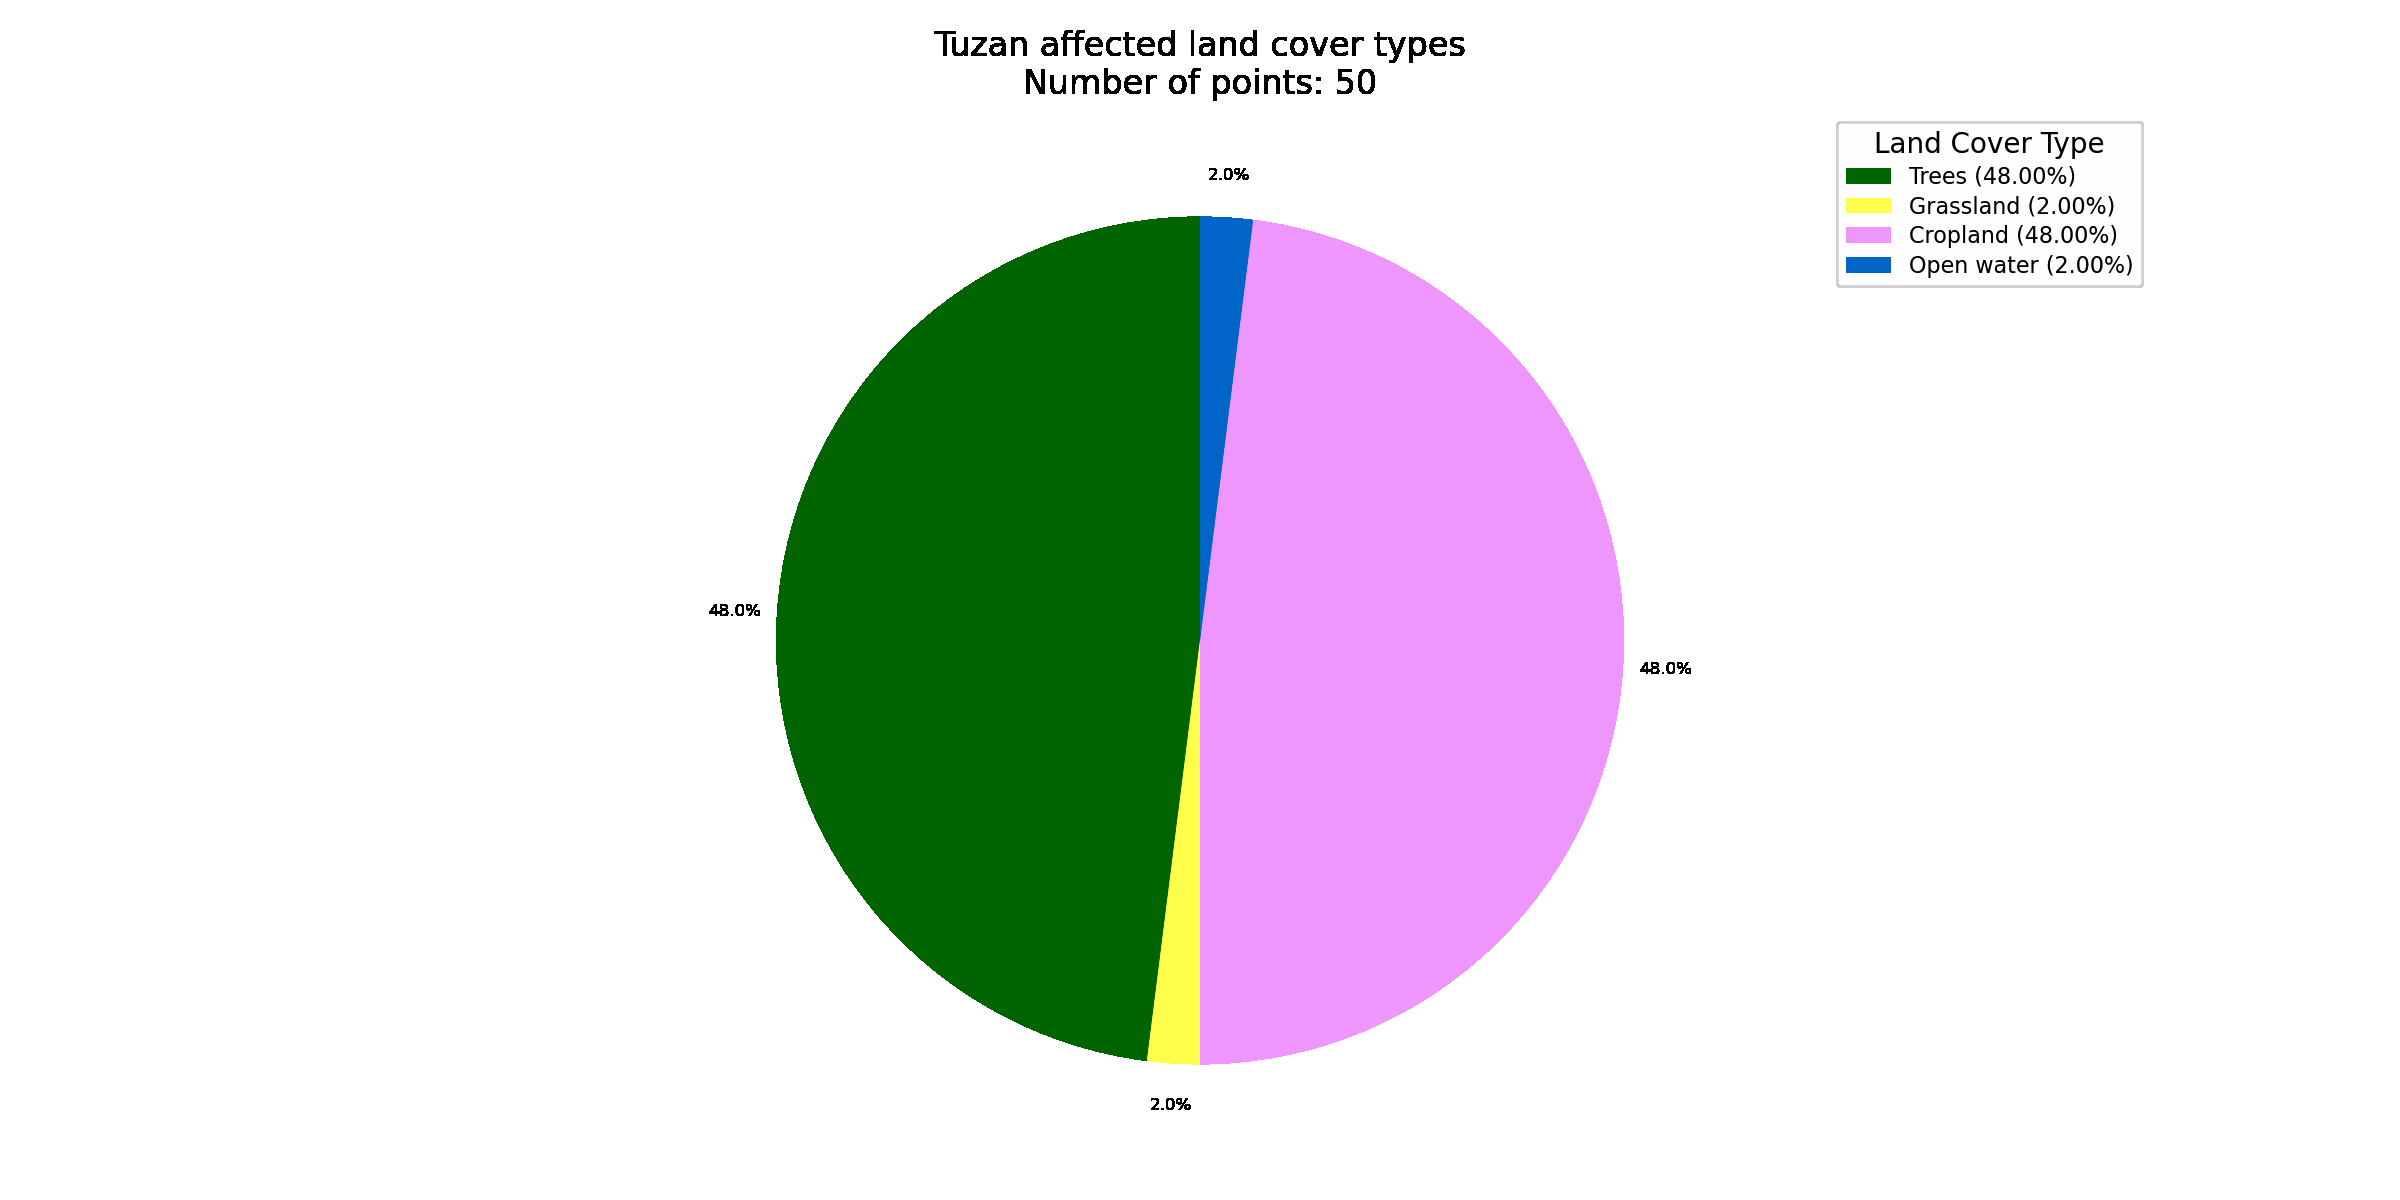

In [37]:
import base64
from IPython import display

def show_gif(fname):
    with open(fname, 'rb') as fd:
        b64 = base64.b64encode(fd.read()).decode('ascii')
    return display.HTML(f'<img src="data:image/gif;base64,{b64}" />')

show_gif(f'output/{FIRE_NAME}/pie_charts/{FIRE_NAME}.gif')

<a name="interactive-map"></a>
## Create interactive map

Finally, we create an interactive map using `geemap` to visualize the coordinates of the fire on a map, also adding the land cover layer.

In [20]:
import utils.plot_map as pm

In [39]:
while True:
    try:
        print("\nEnter the percentage of points to add to the map: ")
        prob = float(input()) / 100
        if 0 < prob <= 1:
            break
        else:
            raise ValueError
    except ValueError:
        print('Please enter a valid number.')


Enter the percentage of points to add to the map: 


In [24]:
fire_map = pm.create_map(
    FIRE_NAME, prob, choice,
    seed=SEED,
    zoom=5,
    cluster=True,
    minimap=False
)

NameError: name 'prob' is not defined

The main advantage of notebooks is that we can also display the map in a cell, instead of in the browser:

In [44]:
fire_map

Map(center=[44.461277884479486, -0.5791268915111112], controls=(WidgetControl(options=['position', 'transparen…

**Please note** that if you choose the option `cluster=False`, the markers will not appear in the saved file. They only appear when you add a cluster to the map.

In [45]:
if not os.path.exists(OUTPUT_MAPS):
    os.makedirs(OUTPUT_MAPS)

pm.save_map(fire_map, FIRE_NAME, OUTPUT_MAPS, wind=False)
pm.open_map(OUTPUT_MAPS, wind=False)

<a name="wind-data"></a>
# Wind Data

In [7]:
import utils.wind_data as wind
from ipyleaflet import basemaps, basemap_to_tiles

In [8]:
year = WILDFIRE_DATE.strftime('%Y')
month = WILDFIRE_DATE.strftime('%m')
day = WILDFIRE_DATE.strftime('%d')
hours = ['12:00']
center = (LATITUDE, LONGITUDE)

In [9]:
output_file = wind.retrieve_wind_data(FIRE_NAME, year, month, day, hours)
print('Output file:', output_file)

File already exists.
Output file: data/nc_files/wind_data_tuzan_2020_07_27.nc


In [10]:
ds = wind.open_nc_data(output_file)
print(ds)

<xarray.Dataset>
Dimensions:    (longitude: 144, latitude: 73, time: 1)
Coordinates:
  * longitude  (longitude) float32 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * latitude   (latitude) float32 90.0 87.5 85.0 82.5 ... -85.0 -87.5 -90.0
  * time       (time) datetime64[ns] 2020-07-27T12:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2021-12-28 17:25:32 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...


In [11]:
ds = wind.reshape_data(ds)

<a name="wind-map"></a>
## Create wind map

In [18]:
wind_map = wind.create_map(
    ds, center, choice,
    zoom=5,
    # basemap=basemaps.CartoDB.DarkMatter,
    basemap=basemaps.Esri.WorldImagery
)

In [19]:
wind_map

Map(center=[44.459819, -0.575544], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox…

You can execute the next cell to add a layer to the map, which will automatically update. More basemaps are available here: https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html.

In [22]:
# add a basemap as layer
# m.add_layer(basemap_to_tiles(basemaps.Esri.WorldImagery))
wind_map.add_layer(basemap_to_tiles(basemaps.CartoDB.DarkMatter))

In [23]:
pm.save_map(wind_map, FIRE_NAME, OUTPUT_MAPS, wind=True)
pm.open_map(OUTPUT_MAPS, wind=True)